# Model selection (using developed package)

**Objective**
- Test developed package and reproduce results of the reference notebook (02_Model_Selection)

In [1]:
# Configuration for documentation
save_fig = False
figure_saving_folder = '../docs/figures'

In [2]:
from ind_machine_anomaly_detection.config.core import config, PipelineConfig 
from ind_machine_anomaly_detection.data.machine_data import MachineSensorDataCSV

from ind_machine_anomaly_detection.pipelines.data_ingestion import clean_data 
from ind_machine_anomaly_detection.pipelines.features import build_features_candidates, select_features 
from ind_machine_anomaly_detection.pipelines.train_test_split import split_data 
from ind_machine_anomaly_detection.pipelines.scalers import get_pipeline_scaling

## 0. Importing the data

In [3]:
data = MachineSensorDataCSV(config.machine_data_catalog, 
                           config.labels_data_catalog, 
                           load_instances=True,
                           load_labels=True)

## 1. Spliting the data into training and testing sets

In [4]:
data_train, data_test = split_data(data)

## 2. Building the features candidates

In [5]:
# Pipeline configuration for development

pipeline_config_dict = {
    # Scaling pipeline
    'channels_spectrum_in_frequency_scalers': ['ch1', 'ch2', 'ch3'],
    'channels_peaks_positions_scalers': ['ch1', 'ch2', 'ch3'],
    'channels_and_variables_min_max_scalers': {
        'ch1': ['ffund', 'rms', 'mean', 'median', 'skew', 'kurtosis'],
        'ch2': ['ffund', 'rms', 'mean', 'median', 'skew', 'kurtosis'],
        'ch3': ['ffund', 'rms', 'mean', 'median', 'skew', 'kurtosis']
    },
    
    # Features building
    ## Related to spectrum in frequency
    'number_max_freq_spectrum': 200,
    'min_perc_samples_count_peaks_freq_spectrum': 0.5,
    'number_ordered_peaks_freq_spectrum': 5,
    ## Related to THD+N estimation
    'thdn_beta_filter': 38,
    'thdn_n_harm': 5,
    'thdn_wind_func_ratio': 0.1,
    'thdn_f_max': 250,

    ## Features selection
    'features_cols': [],
    
    # Model configuration (SVC) Not usefull here
    'C': 1.0,
    'kernel': 'linear',
    'allowed_kernel_types': ['linear']

}


pipeline_config_dev = PipelineConfig(**pipeline_config_dict)

In [6]:
data_feat_candidates = build_features_candidates(data=data_train, pipeline_config=pipeline_config_dev)
data_feat_candidates.head()

,ch1_X_9,ch1_X_18,ch1_X_27,ch1_X_36,ch1_X_46,ch1_X_55,ch1_X_64,ch1_X_73,ch1_X_82,ch1_X_91,...,ch1_skew,ch2_mean,ch2_median,ch2_kurtosis,ch2_skew,ch3_mean,ch3_median,ch3_kurtosis,ch3_skew,label
3,2.563564,1.365853,0.092879,0.384636,0.340825,0.060776,0.289471,0.187444,0.076032,0.244579,...,0.531198,-0.012052,-0.125662,39.253902,4.363865,-0.000063,-0.000008,4.938717,-0.215155,Before
20,0.222036,0.065019,0.610761,0.018089,0.033224,0.325057,0.013402,0.019223,0.108591,0.012168,...,0.340498,-0.001933,-0.153748,2.028806,1.356666,-0.000056,-0.000024,7.053122,-0.657286,Before
29,2.975726,0.956291,0.554018,0.661499,0.236966,0.416325,0.216303,0.250103,0.342235,0.054066,...,0.406690,0.000245,-0.137985,4.668793,1.920865,-0.000069,-0.000031,11.805494,-0.228615,After
8,2.146664,0.690649,0.254610,0.230817,0.230020,0.185388,0.116419,0.265585,0.189719,0.015480,...,0.287437,-0.008955,-0.096333,49.892086,3.769187,-0.000048,-0.000007,8.678009,-0.115002,Before
37,1.548568,0.176667,0.506983,0.290036,0.228188,0.150543,0.154825,0.057334,0.127822,0.110475,...,0.599666,-0.001928,-0.049362,35.693580,3.792676,-0.000057,-0.000088,625.511752,4.364911,After


In [7]:
X_train = data_feat_candidates.drop(columns='label')
y_train = data_feat_candidates['label'].replace(config.labels_data_catalog.machine_data_labels_encoding).astype(int)

## 3. Pipeline with scaling steps

In [8]:
pipeline_scalers = get_pipeline_scaling(pipeline_config_dev)
pipeline_scalers.steps

[('scaler_spec_ch1', SpecFreqScaler()),
 ('scaler_spec_ch2', SpecFreqScaler(channel='ch2')),
 ('scaler_spec_ch3', SpecFreqScaler(channel='ch3')),
 ('scaler_freq_pos_ch1', FreqPosMinMaxScaler()),
 ('scaler_freq_pos_ch2', FreqPosMinMaxScaler(channel='ch2')),
 ('scaler_freq_pos_ch3', FreqPosMinMaxScaler(channel='ch3')),
 ('scaler_minmax_ch1', MinMaxScalerCustomized()),
 ('scaler_minmax_ch2', MinMaxScalerCustomized(channel='ch2')),
 ('scaler_minmax_ch3', MinMaxScalerCustomized(channel='ch3'))]

## 4. Feature selection

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [10]:
N_TRIALS = 50

cols_features = data_feat_candidates.drop(columns='label').columns
features_selection_count = pd.DataFrame(index=cols_features, data=[0] * len(cols_features), columns=['count'])

pipe_scalers_steps = [step for step in pipeline_scalers.steps]
pipe_scalers_steps.append(('feature_selection', SelectKBest(chi2, k=50)))

for i in range(N_TRIALS):
    X_train_, _, y_train_, _ = train_test_split(
                                                X_train,
                                                y_train,
                                                shuffle=True,
                                                test_size=0.3,
                                                random_state=i
    )
    
    pipeline_feat_selection = Pipeline(pipe_scalers_steps)
    pipeline_feat_selection.fit(X_train_, y_train_)
    features_selected = pipeline_feat_selection.named_steps['feature_selection'].get_feature_names_out()
    
    # Adding to features_selection_count
    features_selection_count.loc[features_selected] += 1

In [11]:
n_features = 15
selected_cols = features_selection_count.sort_values(by='count', ascending=False).index[:n_features].tolist()
print('Selected features: \n -', '\n - '.join(selected_cols))

Selected features: 
 - ch1_freqmax_3
 - ch2_X_146
 - ch2_X_18
 - ch2_X_91
 - ch2_ffund
 - ch2_X_100
 - ch2_rms_ratio
 - ch1_X_91
 - ch2_X_64
 - ch1_kurtosis
 - ch1_skew
 - ch2_mean
 - ch3_X_18
 - ch3_X_164
 - ch2_X_73


## 5. Training the models

Nested-Cross Validation

In [12]:
def score_model_inherent_cv(pipeline, X, y):
    pipeline.fit(X, y)
    score_mean = pipeline.named_steps['clf'].scores_[1].mean()
    score_std = pipeline.named_steps['clf'].scores_[1].std()
    
    return pipeline, score_mean, score_std
    
def score_model_not_cv(pipeline, X, y, cv):
    
    score = []
    model_list = []
    for train_index, test_index in cv.split(X, y):
        X_train_, X_test_ = X.iloc[train_index], X.iloc[test_index]
        y_train_, y_test_ = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train_, y_train_)
        
        score.append(fbeta_score(y_test_, pipeline.predict(X_test_), beta=10))
        model_list.append(pipeline)
        
    best_model_idx = np.argmax(score)
    best_model = model_list[best_model_idx]
        
    return best_model, np.mean(score), np.std(score)
    

def get_score_nested_cv(model, model_params, pipeline_config, n_trials=20, model_with_cv=False):

    scorer = make_scorer(fbeta_score, beta=10)

    test_score_not_nested_mean = []
    test_score_not_nested_std = []
    test_score_nested_mean = []
    test_score_nested_std = []
    
    print('Starting the nested scoring pipeline')
    print('Selected columns: \n\t-', '\n\t-'.join(selected_cols))

    for i in range(n_trials):
        # For each trial, we use cross-validation splits on independently
        # randomly shuffled data by passing distinct values to the random_state
        # parameter.
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i)
        outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)

        # Non_nested scoring
        score_function_params = {'X': X_train[selected_cols], 'y': y_train}
        if model_with_cv: 
            model_params['cv'] = inner_cv
            model_params['scoring'] = scorer
            get_score_function = score_model_inherent_cv
            
        else: 
            score_function_params['cv'] = inner_cv
            get_score_function = score_model_not_cv
            
        pipeline_steps = get_pipeline_scaling(pipeline_config).steps
        pipeline_steps.append(('clf', model(**model_params)))
        
        pipeline = Pipeline(pipeline_steps)
        
        score_function_params['pipeline'] = pipeline
        
        pipeline, score_not_nested_mean, score_not_nested_std = get_score_function(**score_function_params)
        
        test_score_not_nested_mean.append(score_not_nested_mean)
        test_score_not_nested_std.append(score_not_nested_std)

        # Nested CV with parameter optimization
        test_score = cross_val_score(pipeline, 
                                     X_train[selected_cols], 
                                     y_train, 
                                     cv=outer_cv,
                                     scoring=scorer,
                                     n_jobs=2)
        test_score_nested_mean.append(test_score.mean())
        test_score_nested_std.append(test_score.std())
        
    
    # Create DF with scores
    all_scores = {
    "Not nested CV": test_score_not_nested_mean,
    "Not nested CV (std)": test_score_not_nested_std,
    "Nested CV": test_score_nested_mean,
    "Nested CV (std)": test_score_nested_std
    }
    all_scores = pd.DataFrame(all_scores)
    
    mean_test_score = np.mean(test_score_nested_mean)
    median_test_score = np.median(test_score_nested_mean)
    std_test_score = np.mean(test_score_nested_std)
    
    return pipeline, all_scores, mean_test_score, median_test_score, std_test_score

In [13]:
def plot_scores_nested_cv(all_scores):
    _, axs = plt.subplots(1, 2, figsize=(18, 6))
    color = {"whiskers": "black", "medians": "black", "caps": "black"}
    all_scores[['Nested CV', 'Not nested CV']].plot.box(color=color, vert=False, ax=axs[0])
    all_scores[['Nested CV (std)', 'Not nested CV (std)']].plot.box(color=color, vert=False, ax=axs[1])
    axs[0].set_xlabel("Score")
    axs[1].set_xlabel("Score")
    _ = axs[0].set_title("Comparison of mean accuracy obtained on the test sets with\n"
                  "and without nested cross-validation")
    _ = axs[1].set_title("Comparison of std accuracy obtained on the test sets with\n"
                  "and without nested cross-validation")

    plt.show()


Training models

In [14]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer, fbeta_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold, StratifiedKFold

**1st model: Logistic Regression**

In [15]:
selected_cols

['ch1_freqmax_3',
 'ch2_X_146',
 'ch2_X_18',
 'ch2_X_91',
 'ch2_ffund',
 'ch2_X_100',
 'ch2_rms_ratio',
 'ch1_X_91',
 'ch2_X_64',
 'ch1_kurtosis',
 'ch1_skew',
 'ch2_mean',
 'ch3_X_18',
 'ch3_X_164',
 'ch2_X_73']

Starting the nested scoring pipeline
Selected columns: 
	- ch1_freqmax_3
	-ch2_X_146
	-ch2_X_18
	-ch2_X_91
	-ch2_ffund
	-ch2_X_100
	-ch2_rms_ratio
	-ch1_X_91
	-ch2_X_64
	-ch1_kurtosis
	-ch1_skew
	-ch2_mean
	-ch3_X_18
	-ch3_X_164
	-ch2_X_73
Mean score (Nested CV):  0.917730882034322


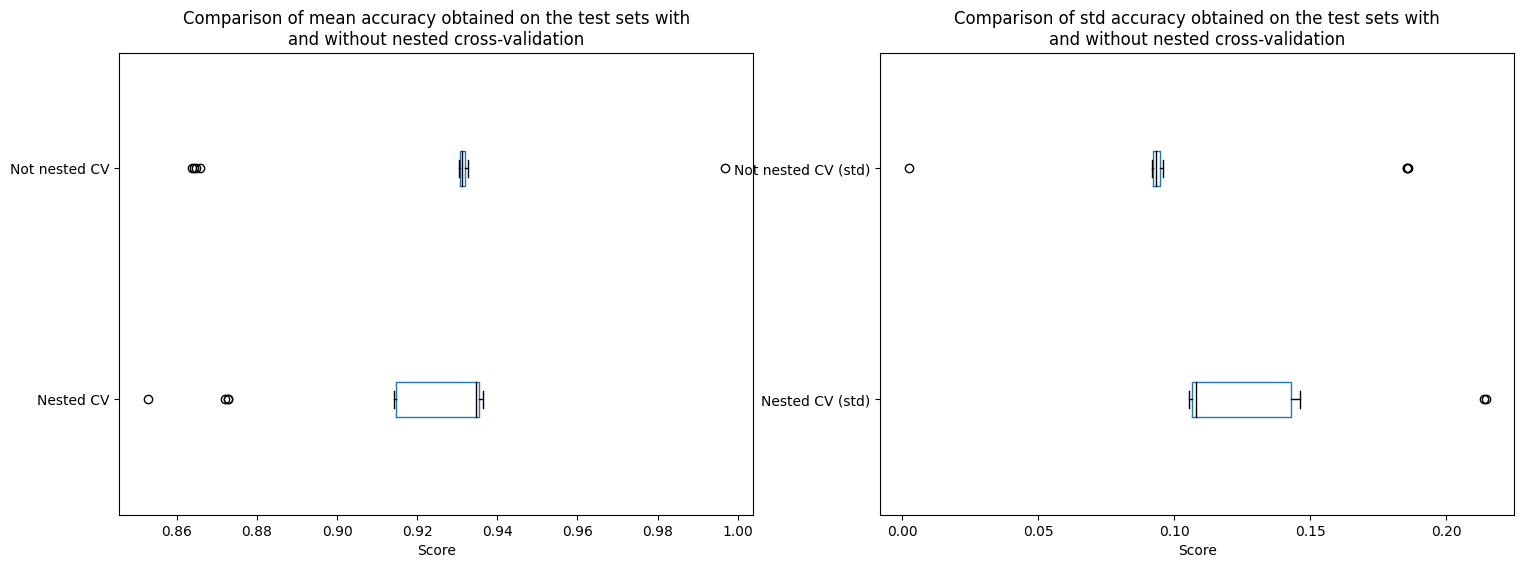

In [16]:
model = LogisticRegressionCV
model_params = {'max_iter': 500, 'Cs': [1.0]}

pipeline_config_dict = {
    # Scaling pipeline
    'channels_spectrum_in_frequency_scalers': ['ch1', 'ch2', 'ch3'],
    'channels_peaks_positions_scalers': ['ch1'],
    'channels_and_variables_min_max_scalers': {
        'ch1': ['skew'],
        'ch2': ['ffund', 'rms', 'mean'],
        #'ch3': ['rms']
    },
    
    # Features building
    ## Related to spectrum in frequency
    'number_max_freq_spectrum': 200,
    'min_perc_samples_count_peaks_freq_spectrum': 0.5,
    'number_ordered_peaks_freq_spectrum': 5,
    ## Related to THD+N estimation
    'thdn_beta_filter': 38,
    'thdn_n_harm': 5,
    'thdn_wind_func_ratio': 0.1,
    'thdn_f_max': 250,

    ## Features selection
    'features_cols': [],
    
    # Model configuration (SVC) Not usefull here
    'C': 1.0,
    'kernel': 'linear',
    'allowed_kernel_types': ['linear']
}

pipeline_config_model_selection = PipelineConfig(**pipeline_config_dict)


_, all_scores_lr, mean_test_score, _, _ = get_score_nested_cv(model, model_params, pipeline_config_model_selection, n_trials=20)
print('Mean score (Nested CV): ',  mean_test_score)

plot_scores_nested_cv(all_scores_lr)

**2nd model: K-Nearest Neighbors**

Starting the nested scoring pipeline
Selected columns: 
	- ch1_freqmax_3
	-ch2_X_146
	-ch2_X_18
	-ch2_X_91
	-ch2_ffund
	-ch2_X_100
	-ch2_rms_ratio
	-ch1_X_91
	-ch2_X_64
	-ch1_kurtosis
	-ch1_skew
	-ch2_mean
	-ch3_X_18
	-ch3_X_164
	-ch2_X_73
Mean score (Nested CV):  0.8886931952636153


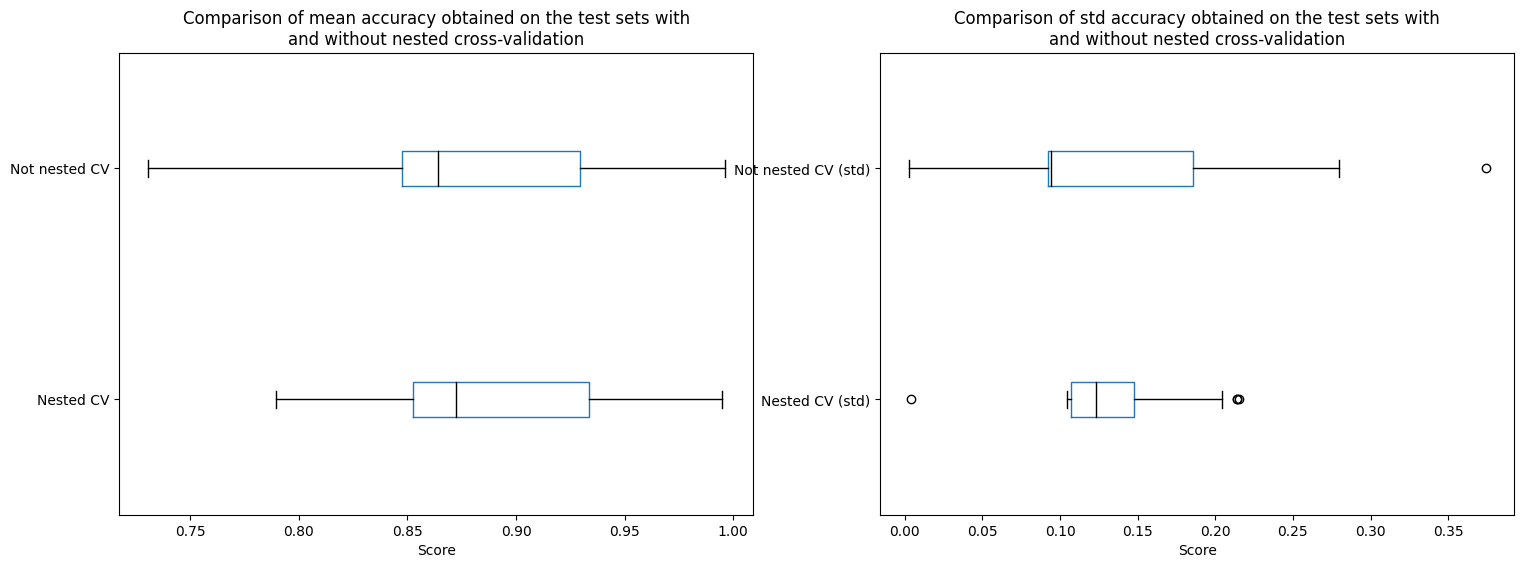

In [17]:
model = KNeighborsClassifier
model_params = {'n_neighbors': 5}

pipeline_config_model_selection = PipelineConfig(**pipeline_config_dict)

_, all_scores_knn, mean_test_score, _, _ = get_score_nested_cv(model, model_params, pipeline_config_model_selection, n_trials=20)
print('Mean score (Nested CV): ',  mean_test_score)

plot_scores_nested_cv(all_scores_knn)

**3rd model: SVM**

Starting the nested scoring pipeline
Selected columns: 
	- ch1_freqmax_3
	-ch2_X_146
	-ch2_X_18
	-ch2_X_91
	-ch2_ffund
	-ch2_X_100
	-ch2_rms_ratio
	-ch1_X_91
	-ch2_X_64
	-ch1_kurtosis
	-ch1_skew
	-ch2_mean
	-ch3_X_18
	-ch3_X_164
	-ch2_X_73
Mean score (Nested CV):  0.9357504024234222


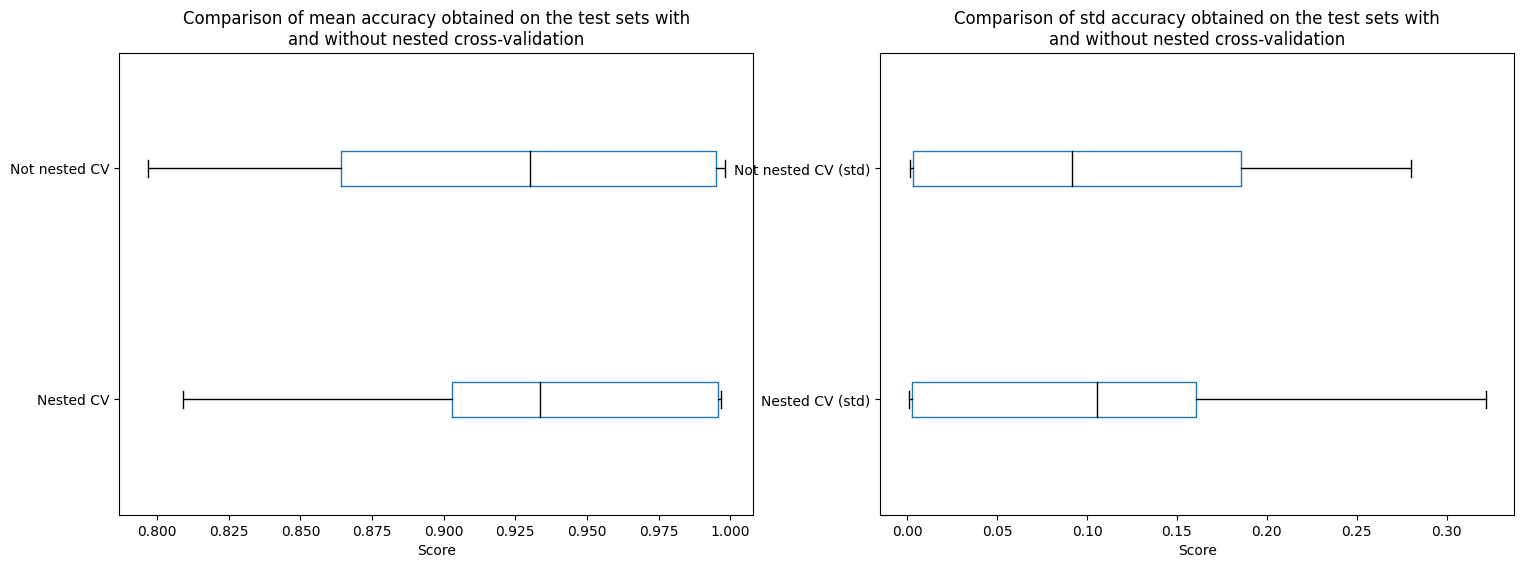

In [18]:
model = SVC
model_params = {'C': 1.0, 'kernel': 'linear'}

pipeline_config_model_selection = PipelineConfig(**pipeline_config_dict)

_, all_scores_svm, mean_test_score, _, _ = get_score_nested_cv(model, model_params, pipeline_config_model_selection, n_trials=20)
print('Mean score (Nested CV): ',  mean_test_score)

plot_scores_nested_cv(all_scores_svm)

## 6. Selecting the model

## 6.1 Comparing the scores (Nested Cross-Validation)

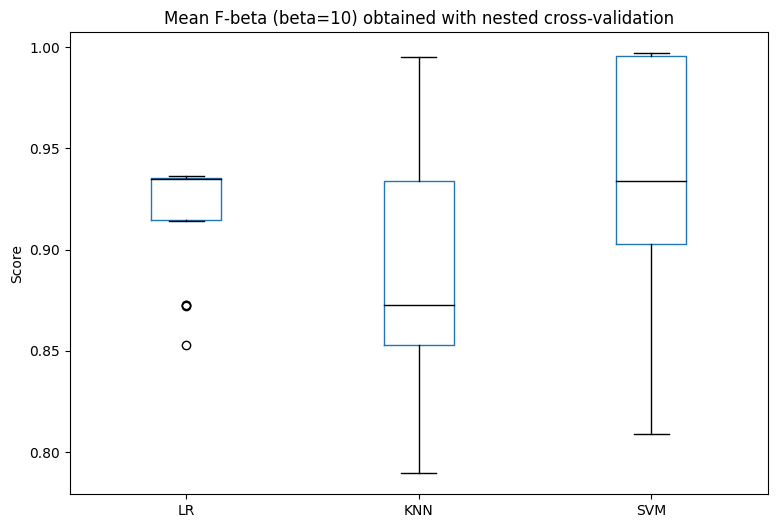

In [19]:
col_plot = 'Nested CV'

list_scores = [
    ('LR', all_scores_lr[col_plot]),
    ('KNN', all_scores_knn[col_plot]),
    ('SVM', all_scores_svm[col_plot])
]

# Renaming the columns
list_scores = [(score[0], score[1].rename(score[0])) for score in list_scores]

# Concatenating the scores series
all_scores = pd.concat([scores[1] for scores in list_scores], axis=1, ignore_index=False)

all_scores

fig, ax = plt.subplots(figsize=(9, 6))
color = {"whiskers": "black", "medians": "black", "caps": "black"}
_ = all_scores.plot.box(color=color, vert=True, ax=ax)
_ = ax.set_ylabel("Score")
_ = ax.set_title("Mean F-beta (beta=10) obtained with nested cross-validation")

if save_fig:
    figure_name = 'comparison_scores.png'
    fig.savefig(f"{figure_saving_folder}/{figure_name}", format='png')

## 6.2 Comparing the confusion matrices

In [20]:
# Getting X_feat and y matrices for test set
pipeline_config_dict = {
    # Scaling pipeline
    'channels_spectrum_in_frequency_scalers': ['ch1', 'ch2', 'ch3'],
    'channels_peaks_positions_scalers': ['ch1'],
    'channels_and_variables_min_max_scalers': {
        'ch1': ['skew'],
        'ch2': ['ffund', 'rms', 'mean'],
        #'ch3': ['rms']
    },
    
    # Features building
    ## Related to spectrum in frequency
    'number_max_freq_spectrum': 200,
    'min_perc_samples_count_peaks_freq_spectrum': 0.25,
    'number_ordered_peaks_freq_spectrum': 5,
    ## Related to THD+N estimation
    'thdn_beta_filter': 38,
    'thdn_n_harm': 5,
    'thdn_wind_func_ratio': 0.1,
    'thdn_f_max': 250,

    ## Features selection
    'features_cols': 
    [
        'ch1_freqmax_3',
         'ch2_X_146',
         'ch2_X_18',
         'ch2_X_91',
         'ch2_ffund',
         'ch2_X_100',
         'ch2_rms_ratio',
         'ch1_X_91',
         'ch2_X_64',
         'ch1_kurtosis',
         'ch1_skew',
         'ch2_mean',
         'ch3_X_18',
         'ch3_X_164',
         'ch2_X_73'
    ],
    
    
    # Model configuration (SVC) Not usefull here
    'C': 1.0,
    'kernel': 'linear',
    'allowed_kernel_types': ['linear']
}

pipeline_config_model_selection = PipelineConfig(**pipeline_config_dict)

data_feat_test = build_features_candidates(
    data=data_test, 
    pipeline_config=pipeline_config_model_selection, 
    training=False
)

X_test = data_feat_test
_, y_test = data_test[:]

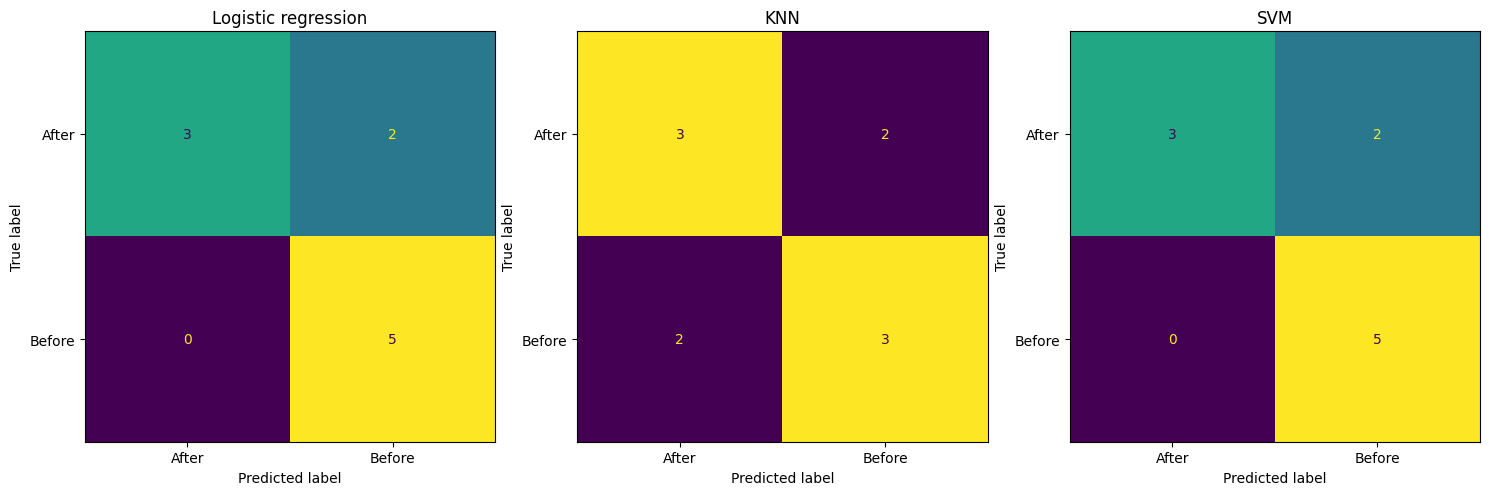

In [21]:
list_models = [
    ('Logistic regression', LogisticRegression(max_iter=500, C=1.0)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('SVM', SVC(C=1.0, kernel='linear'))
]

fig, axs = plt.subplots(1, 3, figsize=(18, 7))

for i, (title, model) in enumerate(list_models):
    
    pipeline_scalers = get_pipeline_scaling(pipeline_config_model_selection)
    pipeline_steps = [step for step in pipeline_scalers.steps]
    pipeline_steps.append(('clf', model))
    
    pipeline = Pipeline(pipeline_steps)
    
    pipeline.fit(X_train[pipeline_config_model_selection.features_cols], y_train)

    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            pipeline.predict(X_test[pipeline_config_model_selection.features_cols]), 
                                            normalize=None, 
                                            display_labels=['After', 'Before'],
                                            colorbar=False,
                                            ax=axs[i])

    _ = axs[i].set(title=title)
    
if save_fig:
    figure_name = 'comparison_confusion_matrices.png'
    fig.savefig(f"{figure_saving_folder}/{figure_name}", format='png')

## 7. Visualizing the results of the models

In [22]:
from sklearn.manifold import TSNE

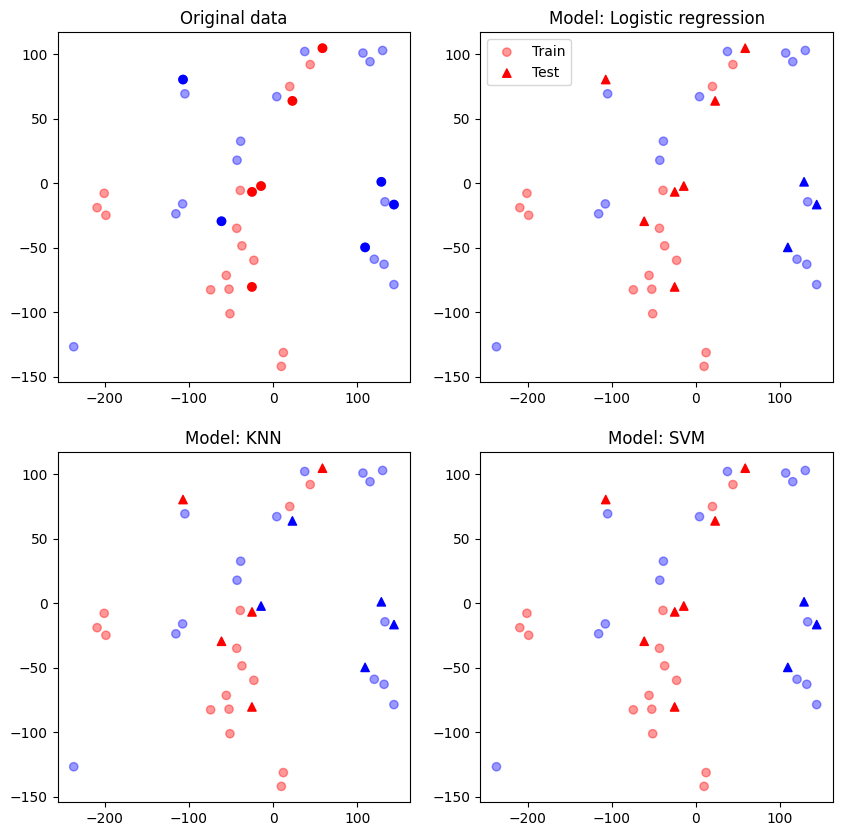

In [23]:
list_models = [
    ('Logistic regression', LogisticRegression(max_iter=500, C=1.0)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('SVM', SVC(C=1.0, kernel='linear'))
]

# Concatenanting train and test sets to plot original dataset
X = pd.concat([X_train, X_test], axis=0, ignore_index=False).sort_index()
y = pd.concat([y_train, y_test['label']], axis=0, ignore_index=False).sort_index()

# Getting pipeline only to scaling
pipeline_scalers = get_pipeline_scaling(pipeline_config_model_selection)
X_scaled = pipeline_scalers.fit_transform(X[selected_cols])

X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=3, init='random').fit_transform(X_scaled)

fig, axs = plt.subplots(int((len(list_models)+1) / 2), 2, figsize=(10, 5 * int((len(list_models) + 1) / 2)) )

def get_color(label_list):
    return ['r' if item==1 else 'b' for item in label_list]

def get_glabels(label_list, train_or_test):
    return ['r' if item==1 else 'b' for item in label_list]

for i, (title, model) in enumerate(list_models):
    
    i = i + 1 # First chart is for original data
    icol = i % 2
    iline = int(i / 2) 
    
    # Getting the pipeline
    pipeline_scalers = get_pipeline_scaling(pipeline_config_model_selection)
    pipeline_steps = [step for step in pipeline_scalers.steps]
    pipeline_steps.append(('clf', model))
    
    # Training
    pipeline = Pipeline(pipeline_steps)
    pipeline.fit(X_train[pipeline_config_model_selection.features_cols], y_train)

    # Predicting
    y_pred = pipeline.predict(X_test[selected_cols].sort_index())
    
    # Plotting training samples
    idx_train = X_train.index.tolist()
    idx_train_bool = [i in idx_train for i in range(1, len(X)+1)]
    
    axs[iline, icol].scatter(
                    x=X_embedded[idx_train_bool,0], 
                    y=X_embedded[idx_train_bool,1], 
                    color=get_color(y_train.sort_index()),
                    alpha=0.4,
                    marker='o',
                    label="Train"
                    )
    
    # Plotting testing samples
    idx_test = X_test.index.tolist()
    idx_test_bool = [i in idx_test for i in range(1, len(X)+1)]
    
    axs[iline, icol].scatter(
                    x=X_embedded[idx_test_bool,0], 
                    y=X_embedded[idx_test_bool,1], 
                    color=get_color(y_pred),
                    alpha=1.0,
                    marker='^',
                    label='Test'
                    )
    
    axs[iline, icol].set(title='Model: {}'.format(title))
    
# Original data    
axs[0, 0].scatter(x=X_embedded[:,0], y=X_embedded[:,1], color=get_color(y.values), alpha=0.4)
axs[0, 0].scatter(x=X_embedded[idx_test_bool,0], y=X_embedded[idx_test_bool,1], color=get_color(y_test.sort_index().values), 
                  alpha=1.0)
axs[0, 0].set(title='Original data')
axs[0,1].legend()

if save_fig:
    figure_name = 'tsne_visualization_results.png'
    fig.savefig(f"{figure_saving_folder}/{figure_name}", format='png')